# Overfitting dan Underfitting dalam Machine Learning

## Pengantar
Overfitting dan underfitting adalah dua masalah utama dalam machine learning yang mempengaruhi performa model. Dalam notebook ini, kita akan:

1. **Memahami Konsep**
   - Apa itu overfitting dan underfitting
   - Bias-variance tradeoff
   - Learning curves

2. **Mendeteksi Masalah**
   - Analisis learning curves
   - Validation curves
   - Cross-validation scores

3. **Solusi dan Teknik**
   - Regularization
   - Feature selection
   - Ensemble methods
   - Early stopping

4. **Studi Kasus Praktis**
   - Regresi polynomial
   - Decision trees
   - Neural networks

Mari kita mulai dengan import library yang diperlukan.

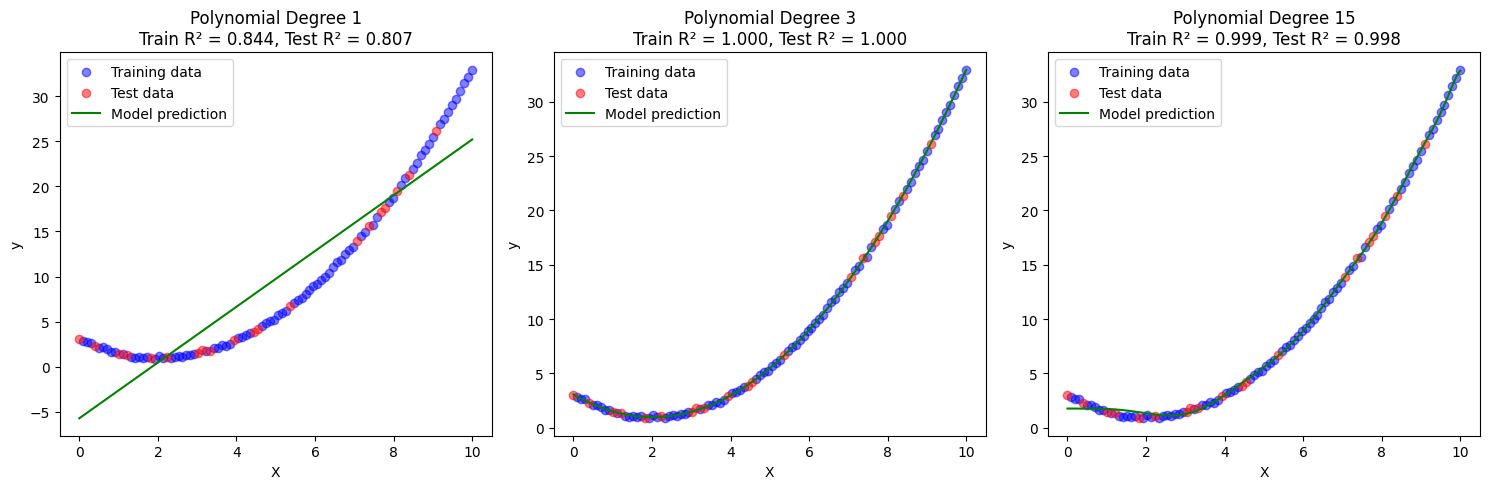

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data for polynomial regression
def generate_nonlinear_data(n_samples=100, noise=0.1):
    X = np.linspace(0, 10, n_samples).reshape(-1, 1)
    y = 0.5 * X**2 - 2 * X + 3 + noise * np.random.randn(n_samples, 1)
    return X, y

X, y = generate_nonlinear_data(n_samples=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit models with different complexities
degrees = [1, 3, 15]  # Linear, good fit, overfit
plt.figure(figsize=(15, 5))

for i, degree in enumerate(degrees, 1):
    plt.subplot(1, 3, i)
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    
    # Generate points for smooth curve
    X_plot = np.linspace(0, 10, 200).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = model.predict(X_plot_poly)
    
    # Calculate scores
    train_score = r2_score(y_train, model.predict(X_poly_train))
    test_score = r2_score(y_test, model.predict(X_poly_test))
    
    # Plot
    plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Training data')
    plt.scatter(X_test, y_test, color='red', alpha=0.5, label='Test data')
    plt.plot(X_plot, y_plot, color='green', label='Model prediction')
    plt.title(f'Polynomial Degree {degree}\nTrain R² = {train_score:.3f}, Test R² = {test_score:.3f}')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()

plt.tight_layout()
plt.show()

# Memahami dan Mengatasi Overfitting dan Underfitting

## 1. Konsep Dasar

### Overfitting
- Terjadi ketika model terlalu kompleks dan "menghafal" data training
- Performa sangat baik pada data training tetapi buruk pada data baru
- Ciri: variance tinggi, model terlalu sensitif terhadap noise dalam data

### Underfitting
- Terjadi ketika model terlalu sederhana untuk menangkap pola dalam data
- Performa buruk baik pada data training maupun data testing
- Ciri: bias tinggi, model tidak cukup fleksibel

### Bias-Variance Tradeoff
- Bias: seberapa jauh prediksi model dari nilai sebenarnya
- Variance: seberapa sensitif model terhadap fluktuasi dalam data training
- Tujuan: mencari keseimbangan optimal antara bias dan variance

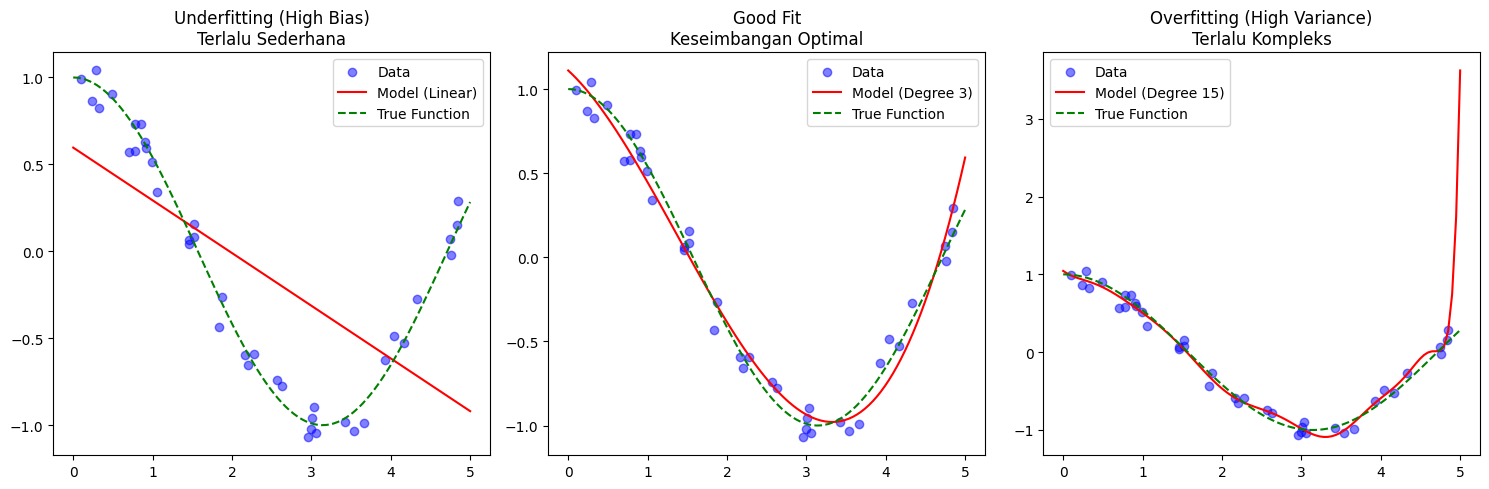

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Generate sample data
np.random.seed(42)
X = np.sort(np.random.rand(40) * 5)
y = np.cos(X) + np.random.normal(0, 0.1, X.shape[0])
X = X.reshape(-1, 1)

# Create and plot models with different complexities
plt.figure(figsize=(15, 5))

# Plot 1: Underfitting (High Bias)
plt.subplot(131)
model_underfit = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('linear', LinearRegression())
])
model_underfit.fit(X, y)

X_test = np.linspace(0, 5, 100).reshape(-1, 1)
y_pred_underfit = model_underfit.predict(X_test)

plt.scatter(X, y, color='blue', alpha=0.5, label='Data')
plt.plot(X_test, y_pred_underfit, color='red', label='Model (Linear)')
plt.plot(X_test, np.cos(X_test), '--', color='green', label='True Function')
plt.title('Underfitting (High Bias)\nTerlalu Sederhana')
plt.legend()

# Plot 2: Good Fit
plt.subplot(132)
model_good = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('linear', LinearRegression())
])
model_good.fit(X, y)
y_pred_good = model_good.predict(X_test)

plt.scatter(X, y, color='blue', alpha=0.5, label='Data')
plt.plot(X_test, y_pred_good, color='red', label='Model (Degree 3)')
plt.plot(X_test, np.cos(X_test), '--', color='green', label='True Function')
plt.title('Good Fit\nKeseimbangan Optimal')
plt.legend()

# Plot 3: Overfitting (High Variance)
plt.subplot(133)
model_overfit = Pipeline([
    ('poly', PolynomialFeatures(degree=15)),
    ('linear', LinearRegression())
])
model_overfit.fit(X, y)
y_pred_overfit = model_overfit.predict(X_test)

plt.scatter(X, y, color='blue', alpha=0.5, label='Data')
plt.plot(X_test, y_pred_overfit, color='red', label='Model (Degree 15)')
plt.plot(X_test, np.cos(X_test), '--', color='green', label='True Function')
plt.title('Overfitting (High Variance)\nTerlalu Kompleks')
plt.legend()

plt.tight_layout()
plt.show()

## 2. Learning Curves

Learning curves menunjukkan bagaimana performa model berubah seiring dengan bertambahnya data training. Ini adalah alat yang sangat berguna untuk mendiagnosis masalah bias dan variance:

- **Underfitting (High Bias)**:
  - Training error tinggi
  - Validation error tinggi
  - Kedua kurva mencapai plateau dengan cepat
  - Gap kecil antara training dan validation error

- **Overfitting (High Variance)**:
  - Training error rendah
  - Validation error tinggi
  - Gap besar antara training dan validation error
  - Validation error masih menurun dengan penambahan data

Mari kita lihat learning curves untuk ketiga model di atas:

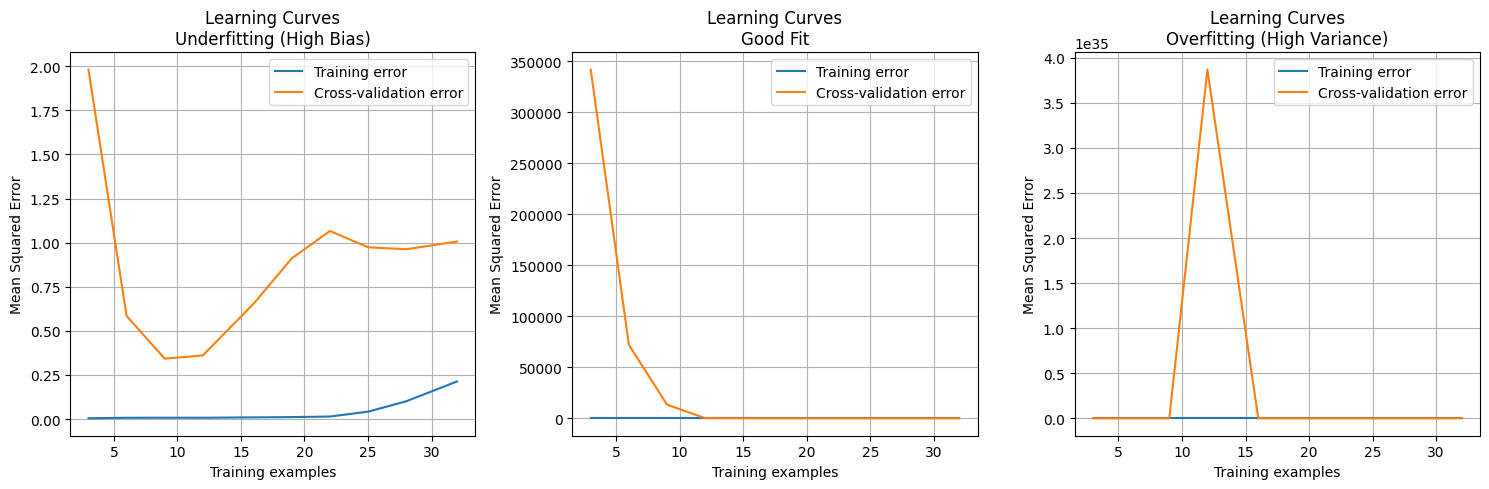

In [99]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, scoring='neg_mean_squared_error'
    )
    
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, val_scores_mean, label='Cross-validation error')
    plt.xlabel('Training examples')
    plt.ylabel('Mean Squared Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(15, 5))

# Learning curve for underfitting model
plt.subplot(131)
model_underfit = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('linear', LinearRegression())
])
plot_learning_curves(model_underfit, X, y, 'Learning Curves\nUnderfitting (High Bias)')

# Learning curve for good fit model
plt.subplot(132)
model_good = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('linear', LinearRegression())
])
plot_learning_curves(model_good, X, y, 'Learning Curves\nGood Fit')

# Learning curve for overfitting model
plt.subplot(133)
model_overfit = Pipeline([
    ('poly', PolynomialFeatures(degree=15)),
    ('linear', LinearRegression())
])
plot_learning_curves(model_overfit, X, y, 'Learning Curves\nOverfitting (High Variance)')

plt.tight_layout()
plt.show()

## 3. Solusi dan Teknik Mengatasi Overfitting dan Underfitting

### Mengatasi Underfitting:
1. Menambah kompleksitas model
2. Menambah fitur yang relevan
3. Mengurangi regularisasi
4. Menggunakan model yang lebih powerful

### Mengatasi Overfitting:
1. Regularisasi (L1, L2)
2. Dropout (untuk neural networks)
3. Early stopping
4. Cross-validation
5. Menambah data training
6. Feature selection/reduction
7. Ensemble methods

Mari kita demonstrasikan penggunaan regularisasi dengan Ridge Regression (L2) dan Lasso (L1):

/home/dihak/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.051e+00, tolerance: 5.482e-02
  model = cd_fast.enet_coordinate_descent(


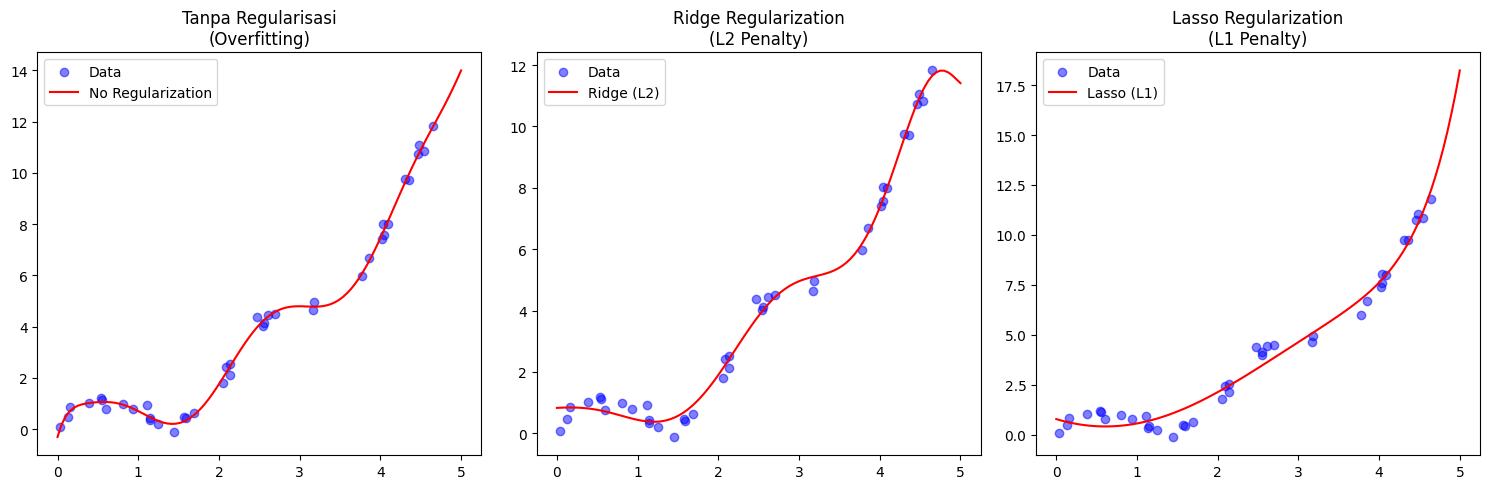

In [100]:
from sklearn.linear_model import Ridge, Lasso

# Generate more complex synthetic data
X = np.sort(np.random.rand(40) * 5)
y = 0.5 * X**2 + np.sin(3*X) + np.random.normal(0, 0.2, X.shape[0])
X = X.reshape(-1, 1)

plt.figure(figsize=(15, 5))

# Without regularization (Overfitting)
plt.subplot(131)
model_overfit = Pipeline([
    ('poly', PolynomialFeatures(degree=10)),
    ('linear', LinearRegression())
])
model_overfit.fit(X, y)

X_test = np.linspace(0, 5, 100).reshape(-1, 1)
y_pred_overfit = model_overfit.predict(X_test)

plt.scatter(X, y, color='blue', alpha=0.5, label='Data')
plt.plot(X_test, y_pred_overfit, color='red', label='No Regularization')
plt.title('Tanpa Regularisasi\n(Overfitting)')
plt.legend()

# With Ridge (L2) regularization
plt.subplot(132)
model_ridge = Pipeline([
    ('poly', PolynomialFeatures(degree=10)),
    ('ridge', Ridge(alpha=1.0))
])
model_ridge.fit(X, y)
y_pred_ridge = model_ridge.predict(X_test)

plt.scatter(X, y, color='blue', alpha=0.5, label='Data')
plt.plot(X_test, y_pred_ridge, color='red', label='Ridge (L2)')
plt.title('Ridge Regularization\n(L2 Penalty)')
plt.legend()

# With Lasso (L1) regularization
plt.subplot(133)
model_lasso = Pipeline([
    ('poly', PolynomialFeatures(degree=10)),
    ('lasso', Lasso(alpha=0.01))
])
model_lasso.fit(X, y)
y_pred_lasso = model_lasso.predict(X_test)

plt.scatter(X, y, color='blue', alpha=0.5, label='Data')
plt.plot(X_test, y_pred_lasso, color='red', label='Lasso (L1)')
plt.title('Lasso Regularization\n(L1 Penalty)')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Kesimpulan dan Tips Praktis

### Mendeteksi Masalah:
1. **Underfitting**:
   - Error training tinggi
   - Error validasi tinggi
   - Model terlalu sederhana
   - Prediksi tidak akurat pada training dan test set

2. **Overfitting**:
   - Error training rendah
   - Error validasi tinggi
   - Gap besar antara error training dan validasi
   - Prediksi sangat baik pada training tapi buruk pada test set

### Tips Praktis:
1. **Selalu mulai sederhana**:
   - Mulai dengan model sederhana
   - Tingkatkan kompleksitas secara bertahap
   - Monitor performa pada validation set

2. **Validasi yang baik**:
   - Gunakan cross-validation
   - Pisahkan test set di awal
   - Evaluasi dengan metrics yang sesuai

3. **Feature Engineering**:
   - Pilih fitur yang relevan
   - Normalisasi/standardisasi data
   - Pertimbangkan feature selection/reduction

4. **Regularisasi**:
   - L1 (Lasso): Untuk feature selection
   - L2 (Ridge): Untuk memperkecil koefisien
   - Elastic Net: Kombinasi L1 dan L2

5. **Data**:
   - Kualitas data lebih penting dari kuantitas
   - Pastikan data bersih dan representatif
   - Pertimbangkan data augmentation jika perlu